In [5]:
import os
import os.path as op
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sys
import scipy
import time
from tqdm import tqdm


import mne
import itertools
# from mne.parallel import parallel_func

from mne.time_frequency import psd_multitaper
from sklearn.linear_model import LinearRegression

In [6]:
data_path = '/Users/bryan/Downloads/Peking_U/data/subj/'

N_JOBS = 1

make_plot = True


sb_list = os.listdir(data_path)
sb_list.remove('.DS_Store')

print(sb_list)

['sb_002', 'sb_003', 'subj_trigger.csv', 'sb_011', 'sb_008', 'sb_001', 'sb_006', 'sb_009', 'sb_999', 'sb_013', 'sb_015', 'sb_012']


In [7]:
sb_name = sb_list[-4]
study_path = data_path+sb_name +"/"+os.listdir(data_path+sb_name)[-1]+"/"
out_path = study_path+'out_file'
subject = sorted(os.listdir(out_path))[0][:-17]
print("Processing subject: %s" % subject)

Processing subject: sb_999


In [8]:
file_name = '/Users/bryan/Downloads/Peking_U/data/subj/sb_999/200923/out_file/sb_999_V1_DurRall_filt_tsss_bp1-40_ds100_epo_cleaned.fif'

In [9]:
#config
freqs = np.arange(6, 40)
n_cycles = freqs / 3.

fmin = 2
fmax = 40
channel_type = 'grad'
theta = 0.003
gamma = 0.5


method = 'hilbert'
lfr = 5
hfr = 30
lfr_band = 2
hfr_band = 4
num_of_bins = 12
sfreq = 100
tmin = 0
tmax = 2.2

channel_picks = ['MEG0522', 'MEG0523', 'MEG0532', 'MEG0533', 'MEG0542', 'MEG0543']

In [179]:
print("Processing subject: %s" % subject)
    # Load epoched data
    # fname_epo = op.join(out_path,
    #                 subject+'_V1_DurRall_filt_tsss_epo_cleaned.fif') #_MEEG_V1_DurRall_filt_tsss_epo_cleaned
fname_epo = op.join(out_path,
                subject+'_V1_DurRall_filt_tsss_bp1-40_ds100_epo_cleaned.fif')

epochs = mne.read_epochs(fname_epo,
                     preload=True,
                     verbose=True).crop(tmin=-0.3, tmax=2.2).pick('grad')



Processing subject: sb_999
Reading /Users/bryan/Downloads/Peking_U/data/subj/sb_999/200923/out_file/sb_999_V1_DurRall_filt_tsss_bp1-40_ds100_epo_cleaned.fif ...


<ipython-input-179-fb58dd872a71>:10: RuntimeWarning: This filename (/Users/bryan/Downloads/Peking_U/data/subj/sb_999/200923/out_file/sb_999_V1_DurRall_filt_tsss_bp1-40_ds100_epo_cleaned.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  verbose=True).crop(tmin=-0.3, tmax=2.2).pick('grad')


    Read a total of 1 projection items:
        Average EEG reference (1 x 64) active
    Found the data of interest:
        t =    -300.00 ...    2200.00 ms
        0 CTF compensation matrices available
Not setting metadata
Not setting metadata
1435 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Removing projector <Projection | Average EEG reference, active : True, n_channels : 64>


In [10]:
"""
===================================
01. 1/f correction
===================================


To isolate oscillatory contributions,

1/f activity was attenuated in the time-frequency data 

by subtracting the linear fit of the 1/f characteristic 

reference:

    [1] Haller, Matar, et al. 
        "Parameterizing neural power spectra."
        BioRxiv (2018): 299859.     




 Parameters
    ----------
    file_name = path for epoch files to be corrected
    
    channel_type = 'eeg','meg','mag' or 'grad'
    
    fmin = Min frequency of interest 
    
    fmax = Max frequency of interest
    
    theta = parameter for selecting peaks to be removed, default as 0.003
    
    gamma = min percentage of left points after removing peaks vaild for fitting, default as 50%
    
    make_plot = whether to make plot of averaged results, default as True
    
 Returns 
    -------
    corrected psd for each channels


""" 

def recip_f_correction(file_name, channel_type = 'grad',fmin = fmin, fmax = fmax,
                        theta = 0.003, gamma = 0.5, make_plot = True):
    
   ####reference: Parameterizing neural power spectra



    print("Processing subject: %s" % subject)
    # Load epoched data
    # fname_epo = op.join(out_path,
    #                 subject+'_V1_DurRall_filt_tsss_epo_cleaned.fif') 
#     fname_epo = op.join(out_path,
#                     subject+'_V1_DurRall_filt_tsss_bp0.01-40_ds100_epo_cleaned.fif')
    fname_epo = op.join(file_name)
    epochs = mne.read_epochs(fname_epo,
                         preload=True,
                         verbose=True).apply_baseline((-0.3,0)).crop(tmin=-0.3, tmax=2.2).pick([channel_type])

    # Run frequency-power decomposition
    psds, freqs = psd_multitaper(epochs, fmin = fmin, fmax = fmax, low_bias=True,   
                                proj=True, n_jobs=1) 

    # psds, freqs = mne.time_frequency.psd_welch(epochs,fmin = fmin,fmax = fmax,n_fft = 128) 

    #averaging over epochs
    psds = np.average(psds,axis = 0)
    # psds = np.log(psds)
    # psds = psds[:,np.where(freqs>2)[0]]
    # freqs = freqs[np.where(freqs>2)]
    if make_plot:
        epochs.plot_psd(fmin = fmin,fmax = fmax)

    ## Format of fitted function 
    def func(x,a,b,c,d):
        return a-b*np.log(c+x**d)

    ######Initial guess for the parameters (length N).
    ##Manually set
    initial_guess = np.array([1e-23,  2e-23, -1,  2e-01])

    ##Auto set
    TEST_INITIAL_GUESS = False
    if TEST_INITIAL_GUESS:
        for i in range(psds.shape[0]):
            X = freqs
            y = psds[i,]
            reg_test , _ = scipy.optimize.curve_fit(func, X,y, maxfev = 100000)
            if func(X[1], *reg_test) > func(X[2], *reg_test):
                initial_guess = reg_test
                print(i)
                break
    ##################################################### 

    psds_fitted = np.zeros(psds.shape)
    for i in range(psds.shape[0]):
    # for i in range(111,112):
    # for i in range(1):
        X = freqs
        y = psds[i,]
        remains = np.where(y<100000)[0]
        X_tmp = X[remains,]
        y_tmp = y[remains,]
        reg_tmp , _ = scipy.optimize.curve_fit(func, X_tmp,y_tmp,p0 = initial_guess, maxfev = 100000)
        k = 0
        while (np.max(y_tmp - func(X_tmp, *reg_tmp)) > np.average(y_tmp)*-theta) and len(remains) > len(X)*gamma:
            X_tmp = X[remains,]
            y_tmp = y[remains,]
            reg_tmp , _ = scipy.optimize.curve_fit(func, X_tmp,y_tmp,p0 = initial_guess,maxfev = 100000)
            k += 1
            if k > 5:
                break
            remains = np.where((y - func(X, *reg_tmp))<=np.average(y_tmp)*-theta)[0]

        reg = reg_tmp
        psds_fitted[i,] = func(X, *reg)
    #     plt.plot(freqs,psds_fitted[i,])
    #     plt.plot(freqs,y)
    #     plt.plot(freqs,y-psds_fitted[i,])

    if np.sum(psds_fitted[:,2]<psds_fitted[:,3]) > 0:
        raise ValueError('Initial guess for curve fitting is inpropriate. Change it manually or set TEST_INITIAL_GUESS as True.')

    psds_corrected = psds - psds_fitted
    plt.plot(freqs,np.average(psds_corrected,axis = 0))
    plt.plot(freqs,np.average(psds_fitted,axis = 0))
    plt.plot(freqs,np.average(psds,axis = 0))
    plt.legend(["corrected psd","1/f charactristic psd",
                        "raw psd"],
                loc = "upper right",fontsize = 10)
    plt.title("PSD Averaged over Channels (%s)"%(channel_type))
    return psds_corrected

Processing subject: sb_999
Reading /Users/bryan/Downloads/Peking_U/data/subj/sb_999/200923/out_file/sb_999_V1_DurRall_filt_tsss_bp1-40_ds100_epo_cleaned.fif ...


<ipython-input-10-ed1e8350ceea>:59: RuntimeWarning: This filename (/Users/bryan/Downloads/Peking_U/data/subj/sb_999/200923/out_file/sb_999_V1_DurRall_filt_tsss_bp1-40_ds100_epo_cleaned.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  verbose=True).apply_baseline((-0.3,0)).crop(tmin=-0.3, tmax=2.2).pick([channel_type])


    Read a total of 1 projection items:
        Average EEG reference (1 x 64) active
    Found the data of interest:
        t =    -300.00 ...    2200.00 ms
        0 CTF compensation matrices available
Not setting metadata
Not setting metadata
1435 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Applying baseline correction (mode: mean)
Removing projector <Projection | Average EEG reference, active : True, n_channels : 64>
No projector specified for this dataset. Please consider the method self.add_proj.
    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows


<ipython-input-10-ed1e8350ceea>:73: RuntimeWarning: (X, Y) fit (-0.3, 43.6) more than 20 mm from head frame origin
  epochs.plot_psd(fmin = fmin,fmax = fmax)


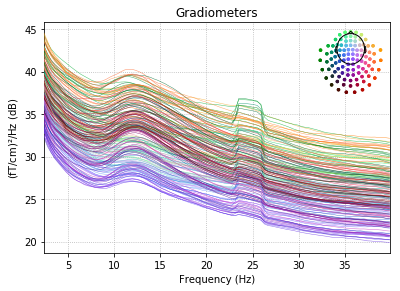

/Users/bryan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:77: RuntimeWarning: invalid value encountered in log
/Users/bryan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:114: RuntimeWarning: invalid value encountered in less_equal


array([[-1.79471375e-26,  2.32521058e-23,  1.38277154e-23, ...,
         1.20105071e-24,  1.26250310e-24,  1.37485133e-24],
       [-1.75800793e-25,  1.62364130e-23,  1.15085150e-23, ...,
         1.27801476e-24,  1.50125008e-24,  1.60341342e-24],
       [-6.32938113e-26,  1.76306376e-23,  1.42328077e-23, ...,
         3.27325033e-25,  3.84037489e-25,  3.70954000e-25],
       ...,
       [-9.50830221e-26,  1.49862506e-23,  1.04209521e-23, ...,
         1.04825185e-24,  1.15030947e-24,  1.22875866e-24],
       [-2.59598995e-26,  2.76521304e-23,  1.41493099e-23, ...,
         6.50580463e-24,  6.73000384e-24,  6.98303434e-24],
       [-1.84669264e-25,  1.23877942e-23,  7.94693038e-24, ...,
         1.13401131e-24,  1.21939431e-24,  1.25083746e-24]])

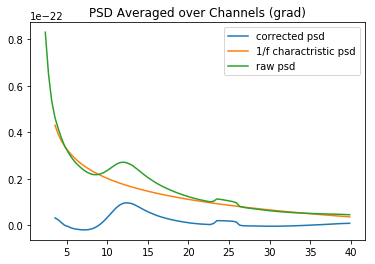

In [11]:
recip_f_correction(file_name, channel_type = 'grad',fmin = fmin, fmax = fmax,
                        theta = 0.003, gamma = 0.5, make_plot = True)

In [7]:
"""
====================================
  Visualize_and_select_channel 
====================================
Parameters
    ----------
    file_name = path for epoch files to be corrected
    
    channel_type = 'eeg','meg','mag' or 'grad'
     
    channel_picks = list of picked channel names, you can select from printed epochs.ch_names
    
"""

def select_and_visualize_channels(file_name,channel_type,channel_picks):  
    print("Processing subject: %s" % subject)
    
    fname_epo = file_name
    epochs = mne.read_epochs(fname_epo,
                         preload=True,
                         verbose=True).pick([channel_type])
    fig = plt.figure()
    ax1 = plt.subplot(1, 2, 1)
    ax2 = plt.subplot(1, 2, 2)
    epochs.plot_sensors(axes=ax1,show = False)
    print(epochs.ch_names)
    ###choose your channels
    epochs.pick(channel_picks)
    if make_plot:
        epochs.plot_sensors(axes=ax2)

In [7]:
# %matplotlib qt5
channel_picks = ['MEG0522', 'MEG0523', 'MEG0532', 'MEG0533', 'MEG0542', 'MEG0543']
# select_and_visualize_channels(file_name,'grad',channel_picks)
# %matplotlib inline

In [204]:
"""
=============================================================
02. Phase-amplitude Decomposition and Modulation Index  
=============================================================


Using the KL divergence to calculate the similiarity 

between one signal's amplitude distribution divided by another signal's phase and

uniform distribution

in order to measure phase-amplitude coupling 

reference:

    [1] Tort, Adriano BL, et al. 
        "Measuring phase-amplitude coupling between neuronal oscillations of different frequencies."
        Journal of neurophysiology 104.2 (2010): 1195-1210.




 Parameters
    ----------
    file_name = path for epoch files to be corrected
    
    channel_picks = list of picked channel names
    
    method = 'hilbert','wavelet','multitaper','mixed',default as 'hilbert',
    
            if 'mixed', use wavelet on lfr , 'multitaper' on hfr
    
    lfr = low frequency of interest for generating phase 
    
    hfr = high frequency of interest for generating power
    
    lfr_band = narrow band for filtering low frequency of interest
    
    hfr_band = narrow band for filtering low frequency of interest
    
    num_of_bins = number of bins used for binned power, default as 12(every π/6 in phase change)
    
    tmin = minimum time point in each epoch of interest
    
    tmax = maximum time point in each epoch of interest
    
    make_plot = whether to make plot of averaged results, default as True
    
 Returns 
    -------
    corrected psd for each channels


""" 

def PAC_MI(file_name, channel_picks = channel_picks,
           method = 'hilbert', lfr = lfr, hfr = hfr, 
           lfr_band = 2,hfr_band = 4, num_of_bins = 12,
           tmin = tmin, tmax = tmax, make_plot = True):
    
    print("Processing subject: %s" % subject)
    # Load epoched data
    # fname_epo = op.join(out_path,
    #                 subject+'_V1_DurRall_filt_tsss_epo_cleaned.fif') #_MEEG_V1_DurRall_filt_tsss_epo_cleaned
#     fname_epo = op.join(out_path,
#                     subject+'_V1_DurRall_filt_tsss_bp1-40_ds100_epo_cleaned.fif')
    fname_epo = file_name
    epochs = mne.read_epochs(fname_epo,
                         preload=True,
                         verbose=True).pick(channel_picks).crop(tmin=tmin, tmax=tmax)
   
    # # Run power-phase decomposition 
    # # using complex morlet wavelet(for low frequency band)/multitaper (for high frequency band)/hilbort transformation

   


    # # power-phase decomposition
    if method == 'hilbert':
        # first band_pass filter  
        s_1 = epochs.copy().filter(lfr-lfr_band//2,lfr+lfr_band//2)     
        epo_hilbert = s_1.apply_hilbert().get_data()
        phase = np.angle(epo_hilbert)
        s_2 = epochs.copy().filter(hfr-hfr_band//2,hfr+hfr_band//2)
        epo_hilbert = s_2.apply_hilbert().get_data()
        power = np.abs(epo_hilbert)
        
    lfr = np.array([lfr])
    hfr = np.array([hfr])
    if method == 'multitaper':
        phase = np.angle(mne.time_frequency.tfr_array_multitaper(epochs.get_data(), sfreq = sfreq, freqs = lfr,
                                        n_cycles = fr/3, output = 'complex'
                                        ))[:,:,0,:]
        power = mne.time_frequency.tfr_array_multitaper(epochs.get_data(), sfreq = sfreq, freqs = hfr,
                                        n_cycles = fr/3, output = 'power'
                                        )[:,:,0,:]
    if method == 'wavelet':
        phase = mne.time_frequency.tfr_array_morlet(epochs.get_data(), sfreq = sfreq, freqs = lfr,
                                        n_cycles = fr/3, output = 'phase'
                                        )[:,:,0,:]
        power = mne.time_frequency.tfr_array_morlet(epochs.get_data(), sfreq = sfreq, freqs = hfr,
                                        n_cycles = fr/3, output = 'power'
                                        )[:,:,0,:]
    if method == 'mixed':
        phase = mne.time_frequency.tfr_array_morlet(epochs.get_data(), sfreq = sfreq, freqs = lfr,
                                        n_cycles = fr/3, output = 'phase'
                                        )[:,:,0,:]
        power = mne.time_frequency.tfr_array_multitaper(epochs.get_data(), sfreq = sfreq, freqs = hfr,
                                        n_cycles = fr/3, output = 'power'
                                        )[:,:,0,:]

    # binning power into equidistant bins
    
    bins_intervals = np.arange(-num_of_bins//2,num_of_bins//2+1)/(num_of_bins//2)*np.pi
    binned_power = np.zeros((power.shape[0],power.shape[1],num_of_bins))

    for j in range(power.shape[0]):
        for k in range(power.shape[1]):
            for i in range(len(bins_intervals)-1):
                bin_index = (phase[j,k,]>=bins_intervals[i])&(phase[j,k,]<=bins_intervals[i+1])
                #mean power at each bin
                binned_power[j,k,i] = np.sum(power[j,k,][bin_index])/np.sum(bin_index)
            #normalization
            binned_power[j,k,:] = binned_power[j,k,:]/np.sum(binned_power[j,k,:])
    if not np.all(binned_power):
        print("Locations of bins with no power",np.where(binned_power == 0))
        raise ValueError('Find bins with no power. Raise the sample frequency or lower the number of bins.')
    if make_plot:
        bar = [(bins_intervals[i]+bins_intervals[i+1])/2 for i in range(num_of_bins)]

        plt.bar(bar,binned_power[0,0,],width = 0.3)
        plt.title('average binned power')

    # Define a function to calculate the KL divergence of two probability distributions.
    # We need to make sure that we don’t include any probabilities equal to 0 
    # because the log of 0 is negative infinity
    def kl_divergence(p, q):
        return np.sum(np.where(p != 0, p * np.log(p / q), 0))

    # calculate modulation index
    def MI(binned_power):
        uniform = np.zeros(binned_power.shape) + 1/len(binned_power)
        max_entropy = np.log(len(binned_power))
        return kl_divergence(binned_power,uniform)/max_entropy

    MI_results = np.zeros(binned_power.shape[:2])

    for j in range(binned_power.shape[0]):
        for k in range(binned_power.shape[1]):
            MI_results[j,k] = MI(binned_power[j,k,])

    print("average MI is :", np.average(MI_results,axis = 0))

In [ ]:
freq_interval = 1
fmin = 1
fmax = 40
tmin = 0.365
tmax = 2
method = 'multitaper'
maxiter = 500
numtol = 1e-17

In [106]:

""" 
======================================
04. Non-parametric Granger Casuality 
======================================


A statistical measure that quantifies the extent to which one time series can predict another. 

We used a non-parametric approach, which estimates GC directly 
from a factorization of the cross-spectral density (CSD) matrix 

reference:

    [1] Dhamala, Mukeshwar, Govindan Rangarajan, and Mingzhou Ding.
        "Estimating Granger causality from Fourier and wavelet transforms of time series data." 
        Physical review letters 100.1 (2008): 018701.
        https://journals.aps.org/prl/pdf/10.1103/PhysRevLett.100.018701
    
    [2] Lionel Barnett and Anil K. Seth, 
        "The MVGC Multivariate Granger Causality Toolbox: A new approach to Granger-causal inference",
        J. Neurosci. Methods 223 (2014), pp 50-68. DOI: 10.1016/j.jneumeth.2013.10.018
        
    [3] https://www.mathworks.com/matlabcentral/fileexchange/78727-the-multivariate-granger-causality-mvgc-toolbox?focused=b10d8835-a5d5-480b-8fe4-a58a70e2a628&tab=function




 Parameters
    ----------
    file_name = path for epoch files to be corrected
    
    channel_picks = list of picked channel names
    
    method = 'wavelet','multitaper','fft'(no time info in GC), default as 'multitaper',
    
    fmin = Min frequency of interest 
    
    fmax = Max frequency of interest
    
    freq_interval = frequency interval for frequency decomposition
    
    tmin = minimum time point in each epoch of interest
    
    tmax = maximum time point in each epoch of interest
    
    maxiter = maximum iteration for spectral faterization
    
    numtol = tolerance for delta during iterations
    
    make_plot = whether to make plot of averaged results, default as True
    
 Returns 
    -------
    Granger Casuality Matrix 
    
    (epoch * time * first_source * second_source * frequence or

     epoch * first_source * second_source * frequence)


""" 

def granger_casuality(file_name ,channel_picks,
                      fmin,fmax,freq_interval,
                      tmin,tmax,method = 'multitaper',
                      maxiter = 500,numtol = 1e-20,make_plot=False):
    
    # Load epoched data
    # fname_epo = op.join(out_path,
    #                 subject+'_V1_DurRall_filt_tsss_epo_cleaned.fif') #_MEEG_V1_DurRall_filt_tsss_epo_cleaned
    fname_epo = file_name

    epochs = mne.read_epochs(fname_epo,
                         preload=True,
                         verbose=True).crop(tmin=tmin, tmax=tmax).apply_baseline((tmin,tmax)).pick(channel_picks)

    # # Run power-phase decomposition 
    # # using complex morlet wavelet(for low frequency band)/multitaper (for high frequency band)/hilbort transformation
    pick_index = np.arange(len(channel_picks))
    pair_index = list(itertools.combinations(pick_index,2))
    if method == 'fft':
        complx = np.fft.fft(epochs.get_data()).copy()
        del epochs
        I = np.zeros((complx.shape[1],complx.shape[1],complx.shape[-1])) *(1+1j)
        residual = []
        time_start=time.time()
        S = np.zeros((complx.shape[0],complx.shape[1],complx.shape[1],complx.shape[2]))*(1+1j)
        for e in range(complx.shape[0]):
            for f in range(complx.shape[2]):
                S[e,:,:,f] = complx[e:e+1,:,f].T @ complx[e:e+1,:,f].conj()        
            S = np.average(S,axis = 0)
            for i in range(len(pair_index)):
                a = pair_index[i][0]
                b = pair_index[i][1]
                s = S[[a,b],][:,[a,b],]
                H,SIG, _,delta = cpsd_to_var_new(s,maxiter =maxiter, numtol =numtol,calculate_delta = True)
                I[a,b,:] = np.log(S[a,a,:]/(S[a,a,:]-((SIG[1,1]-SIG[0,1]**2/SIG[0,0])*np.abs(H[0,1,:])**2)))
                I[b,a,:] = np.log(S[b,b,:]/(S[b,b,:]-((SIG[0,0]-SIG[1,0]**2/SIG[1,1])*np.abs(H[1,0,:])**2)))
                residual.append(delta)
        time_end=time.time()
        print('time cost',time_end-time_start,'s')
        print('Max tolerance:',numtol,'average residual:',np.average(residual))
        ## Granger Casulity Matrix 
        # epoch * first_source * second_source * frequence
        # NOTE : layout of frequence should refer to fft
        return I
       
    freqs = np.arange(fmin,fmax,freq_interval)
    # # transform to complex
    if method == 'wavelet':

        complx = mne.time_frequency.tfr_array_morlet(epochs.get_data(), sfreq = sfreq, freqs = freqs,
                                        n_cycles = freqs/3, output = 'complex'
                                        )

    if method == 'multitaper':
        complx = mne.time_frequency.tfr_array_multitaper(epochs.get_data(), sfreq = sfreq, freqs = freqs,
                                        n_cycles = freqs/3, output = 'complex'
                                        )
    del epochs
    # Initialize granger casulity matrix
    # epoch * time * first_source * second_source * frequence
    I = np.zeros((complx.shape[-1],complx.shape[1],complx.shape[1],complx.shape[2])) *(1+1j)

    time_start=time.time()
    residual = []
    for t in tqdm(range(complx.shape[-1])):
        S = np.zeros((complx.shape[0],complx.shape[1],complx.shape[1],complx.shape[2]))*(1+1j)
        for e in range(complx.shape[0]):
            for f in range(complx.shape[2]):
                S[e,:,:,f] = complx[e:e+1,:,f,t].T @ complx[e:e+1,:,f,t].conj()
        S = np.average(S,axis = 0)
        for i in range(len(pair_index)):
            a = pair_index[i][0]
            b = pair_index[i][1]
            s = S[[a,b],][:,[a,b],]
            H,SIG, _,delta = cpsd_to_var(s,maxiter =maxiter, numtol =numtol,calculate_delta = True)
            I[t,a,b,:] = np.log(S[a,a,:]/(S[a,a,:]-((SIG[1,1]-SIG[0,1]**2/SIG[0,0])*np.abs(H[0,1,:])**2)))
            I[t,b,a,:] = np.log(S[b,b,:]/(S[b,b,:]-((SIG[0,0]-SIG[1,0]**2/SIG[1,1])*np.abs(H[1,0,:])**2)))
            residual.append(delta)
    print('Max tolerance:',numtol,'average residual:',np.average(residual))
    ## Granger Casulity Matrix 
    # epoch * time * first_source * second_source * frequence
    return I


#Utils


# Calculate autocovariance sequence from cross-power spectral density
# %
# % <matlab:open('cpsd_to_autocov.m') code>

# %
# % _input_
# %
# %     S          Flipped cross-power spectral density (cpsd) matrix
# %     q          number of autocovariance lags to calculate (default: automatic)
# %
# % _output_
# %
# %     G          autocovariance sequence
# %
# %% Description
# %
# % Calculates the autocovariance sequence |G| defined as [[ii_acseq.png]] to |q|
# % lags from the cross-power spectral density (cpsd) |S|. This is essentially an
# % inverse Fourier transform

# def cpsd_to_autocov(S):
#     (n,_,h) = S.shape
#     fres = h-1
#     q = fres-1
    
#     q1 = q+1
#     G = np.fft.ifft(np.concatenate([np.flip(S[:,:,1:fres+1].conj(),2),S[:,:,0:fres]],axis = 2),2*fres)
#     r = np.ones(int(np.ceil(q1/2)))  
#     sgn = np.array([r,-r]).T.reshape(1,-1)
#     G = np.real((sgn * G[:,:,:q1].reshape((n*n,q1),order='F')).reshape((n,n,q1),order='F'))
#     return G


#we need S,G0, maxiter,numtol
#S.shape (n,n,h(len(freq)))
#  numtol  numerical tolerance (default: 1e-10)

# Spectral factorisation: calculate VAR parameters from cross-power spectral density
# %
# % <matlab:open('cpsd_to_var.m') code>
# %
# %
# % _input_
# %
# %     S          cross-power spectral density (cpsd) matrix
# %     G0         covariance matrix of VAR process (default: calculated automatically from cpsd)
# %     maxiters   maximum iterations (default: 100)
# %     numtol     numerical tolerance (default: 1e-10)
# %
# % _output_
# %
# %     H          VAR transfer function matrix
# %     SIG        VAR residuals covartiance matrix
# %     iters      number of iterations performed
# %
# %% Description
# %
# % Calculates the transfer function |H| and residuals covariance matrix |SIG|
# % from the cpsd |S| and covariance matrix |G0| of a VAR process, using Wilson's
# % spectral factorisation algorithm [2]. If |G0| is not supplied (default), then
# % |G| is calculated from |S| (see <cpsd_to_autocov.html |cpsd_to_autocov|>) and
# % |G0| set to |G(:,:,1)|. The actual number of iterations performed is returned
# % in |iters|. If the algorithm fails to converge to numerical tolerance |numtol|
# % within |maxiters| iterations, an exception |MVGC:XMaxItrs| is thrown.

def cpsd_to_var(S,maxiter = 300, numtol = 1e-15,calculate_delta = False):
    (n,_,h) = S.shape
    h2 = 2*(h-1)
    # h2 = 2*h-1
    # extend spectrum
    SX = np.zeros((n,n,h2))*(1+1j)
    SX[:,:,0] = S[:,:,0]
    for k in range(1,h):
        SX[:,:,k] = S[:,:,k]
        SX[:,:,h2-k] = S[:,:,k].T
    #     SX[:,:,2*h-k-1] = S[:,:,k].T
    # initialise P
    G = np.fft.ifft(SX).real
    A0 = np.linalg.cholesky(G[:,:,0]).T

    P = np.zeros((n,n,h2)) * (1+1j)
    for i in range(h2):
        P[:,:,i] = A0

    I = np.eye(n)
    g = np.zeros((n,n,h2))* (1+1j)
    d = 0
    for iters in range(maxiter):
        # calculate g
        for k in range(h2):
            Pkinv = np.linalg.inv(P[:,:,k])
            g[:,:,k] = (Pkinv@SX[:,:,k]@(Pkinv.conj().T))+I

        # calculate [g]+ (take positive lags only and half of the zero lag) 
        beta = np.fft.ifft(g,g.shape[-1])
        Gp = beta
        beta0 = 0.5*beta[:,:,0]
        Gp[:,:,0] = np.triu(beta0)
        Gp[:,:,h:] = 0
        gp = np.fft.fft(Gp,Gp.shape[-1]) 
    #     R = -np.triu(beta0,-1)
    #     R = R - R.conj()
        # Update P

        Pold = P.copy()
        dold = d
        for k in range(h2):
            P[:,:,k] = P[:,:,k]@(gp[:,:,k])

        d = np.max(np.abs(P-Pold))
        if np.abs(dold - d) < numtol:
            break
    #     elif (dold != 0) and (d > dold):
    #         P = Pold
    #         break
#         print(np.abs(dold - d))
    if iters == maxiter-1:
        raise ValueError('MaxItrs,tolerance not met at %d iterations (norm = %e, numtol = %e)'%(maxiter,np.max(np.abs(d-dold)),numtol))
    if calculate_delta:
        D = np.zeros(S.shape)*(1+1j)
        for k in range(h):
            D[:,:,k] = (S[:,:,k] - P[:,:,k]@P[:,:,k].conj().T)
        delta = np.max(np.abs(D))
    # calculate coefficients and residuals covariance
    AA = np.real(np.fft.ifft(P,P.shape[-1]))
    A0 = AA[:,:,0] 
    SIG = (A0@A0.T).real
    A0inv = np.linalg.inv(A0)
    H = np.zeros((n,n,h))*(1+1j)
    for k in range(h):
        H[:,:,k] = P[:,:,k]@A0inv
    if calculate_delta:
        return H,SIG,i,delta
    return H,SIG,i

def cpsd_to_var_new(S,maxiter = 300, numtol = 1e-17,calculate_delta = False):
    (n,_,h) = S.shape
#     h2 = 2*(h-1)
    h2 = 2*h-1
    # extend spectrum
    SX = np.zeros((n,n,h2))*(1+1j)
    SX[:,:,0] = S[:,:,0]
    for k in range(1,h):
        SX[:,:,k] = S[:,:,k]
#         SX[:,:,h2-k] = S[:,:,k].T
        SX[:,:,2*h-k-1] = S[:,:,k].T
    # initialise P
    G = np.fft.ifft(SX).real
    A0 = np.linalg.cholesky(G[:,:,0]).T

    P = np.zeros((n,n,h2)) * (1+1j)
    for i in range(h2):
        P[:,:,i] = A0

    I = np.eye(n)
    g = np.zeros((n,n,h2))* (1+1j)
    d = 0
    for iters in range(maxiter):
        # calculate g
        for k in range(h2):
            Pkinv = np.linalg.inv(P[:,:,k])
            g[:,:,k] = (Pkinv@SX[:,:,k]@(Pkinv.conj().T))+I

        # calculate [g]+ (take positive lags only and half of the zero lag) 
        beta = np.fft.ifft(g,g.shape[-1])
        Gp = beta
        beta0 = 0.5*beta[:,:,0]
        Gp[:,:,0] = np.triu(beta0)
        Gp[:,:,h:] = 0
        gp = np.fft.fft(Gp,Gp.shape[-1]) 
    #     R = -np.triu(beta0,-1)
    #     R = R - R.conj()
        # Update P

        Pold = P.copy()
        dold = d
        for k in range(h2):
            P[:,:,k] = P[:,:,k]@(gp[:,:,k])

        d = np.max(np.abs(P-Pold))
        if np.abs(dold - d) < numtol:
            break
    #     elif (dold != 0) and (d > dold):
    #         P = Pold
    #         break
#         print(np.abs(dold - d))
    if iters == maxiter-1:
        raise ValueError('MaxItrs,tolerance not met at %d iterations (norm = %e, numtol = %e)'%(maxiter,np.max(np.abs(d-dold)),numtol))
    if calculate_delta:
        D = np.zeros(S.shape)*(1+1j)
        for k in range(h):
            D[:,:,k] = (S[:,:,k] - P[:,:,k]@P[:,:,k].conj().T)
        delta = np.max(np.abs(D))
    # calculate coefficients and residuals covariance
    AA = np.real(np.fft.ifft(P,P.shape[-1]))
    A0 = AA[:,:,0] 
    SIG = (A0@A0.T).real
    A0inv = np.linalg.inv(A0)
    H = np.zeros((n,n,h))*(1+1j)
    for k in range(h):
        H[:,:,k] = P[:,:,k]@A0inv
    if calculate_delta:
        return H,SIG,i,delta

    return H,SIG,i

In [ ]:
# """ 
# ======================================
# 03. Inter-trial Phase Coherence 
# ======================================


# """ 

# def ITPC():
   
#     fname_epo = file_name

#     epochs = mne.read_epochs(fname_epo,
#                          preload=True,
#                          verbose=True).crop(tmin=tmin, tmax=tmax).pick(channel_types)


#     # # decomposition
#     if method == 'wavelet':

#         complx = mne.time_frequency.tfr_morlet(epochs.get_data(), freqs = freqs,
#                                         n_cycles = freqs/3
#                                         )

#     if method == 'multitaper':
#         complx = mne.time_frequency.tfr_multitaper(epochs.get_data(), freqs = freqs,
#                                         n_cycles = fr/3)
    
#      phase   
        

In [69]:
# freq_interval = 1
# fmin = 1
# fmax = 40
# tmin = 0.365
# tmax = 2
# method = 'wavelet'
# channel_types = 'grad'

# print("Processing subject: %s" % subject)
# # Load epoched data
# # fname_epo = op.join(out_path,
# #                 subject+'_V1_DurRall_filt_tsss_epo_cleaned.fif') #_MEEG_V1_DurRall_filt_tsss_epo_cleaned
# fname_epo = op.join(out_path,
#                     subject+'_V1_DurRall_filt_tsss_bp1-40_ds100_epo_cleaned.fif')

# epochs = mne.read_epochs(fname_epo,
#                      preload=True,
#                      verbose=True).crop(tmin=tmin, tmax=tmax).pick(channel_types)


# #     pick_index = np.arange(len(channel_picks))
# #     pair_index = list(itertools.combinations(pick_index,2))

# freqs = np.arange(fmin,fmax,freq_interval)
# # # decomposition
# if method == 'wavelet':
#     power, itc = mne.time_frequency.tfr_morlet(epochs, freqs = freqs,
#                                                n_cycles = freqs/3)

# if method == 'multitaper':
#     power, itc = mne.time_frequency.tfr_multitaper(epochs, freqs = freqs,
#                                                    n_cycles = fr/3)
# # power.plot_topo(baseline=(-0.5, 0), mode='logratio', title='Average power')
# # power.plot([82], baseline=(-0.5, 0), mode='logratio', title=power.ch_names[82])

# # fig, axis = plt.subplots(1, 2, figsize=(7, 4))
# # power.plot_topomap(ch_type='grad', tmin=0.5, tmax=1.5, fmin=8, fmax=12,
# #                    baseline=(-0.5, 0), mode='logratio', axes=axis[0],
# #                    title='Alpha', show=False)
# # power.plot_topomap(ch_type='grad', tmin=0.5, tmax=1.5, fmin=13, fmax=25,
# #                    baseline=(-0.5, 0), mode='logratio', axes=axis[1],
# #                    title='Beta', show=False)
# # mne.viz.tight_layout()
# # plt.show()    


Processing subject: sb_999
Reading /Users/bryan/Downloads/Peking_U/data/subj/sb_999/200923/out_file/sb_999_V1_DurRall_filt_tsss_bp1-40_ds100_epo_cleaned.fif ...


<ipython-input-69-69f48d61c6ea>:18: RuntimeWarning: This filename (/Users/bryan/Downloads/Peking_U/data/subj/sb_999/200923/out_file/sb_999_V1_DurRall_filt_tsss_bp1-40_ds100_epo_cleaned.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  verbose=True).crop(tmin=tmin, tmax=tmax).pick(channel_types)


    Read a total of 1 projection items:
        Average EEG reference (1 x 64) active
    Found the data of interest:
        t =    -300.00 ...    2200.00 ms
        0 CTF compensation matrices available
Not setting metadata
Not setting metadata
1435 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Removing projector <Projection | Average EEG reference, active : True, n_channels : 64>


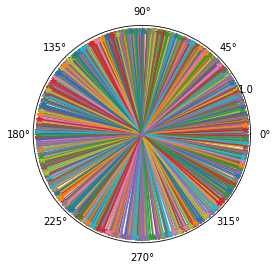

In [64]:
###ITPC

for x in com[:,0,0,epochs.times == 0]:
    plt.polar([0,np.angle(x)],[0,1],marker='*')